In [3]:
from mongo import *
%matplotlib inline

In [4]:
(predictors, pool, likes, users, user_hot, user_num) = gather_mongo_data()
data = split_datasets(users, user_hot, predictors, likes)
training_data = xgb.DMatrix(data["training"]["X"], label=data["training"]["y"])
validation_data = xgb.DMatrix(data["validation"]["X"], label=data["validation"]["y"])

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450


In [33]:
best_score = 1
best_params = []

eta = 0.1
subsample = 0.5
max_depth = 1

for subsample in [0.5, 1]:
    for max_depth in [1, 2, 3, 4, 6]:
        params = {"nthread": 4, "eta": eta, "max_depth": max_depth, "subsample": subsample, "silent": 1}
        print("params: " + str(eta) + "," + str(max_depth) + ", " + str(subsample))

        num_early_stop = 100
        cycle = 0

        trained = xgb.train(params, training_data, num_boost_round=5000, evals = [[validation_data, "validation"]], 
                  feval = lambda preds, dtrain: 
                            list([["error", (1 - calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, preds, dtrain.get_label()))]]),
                            early_stopping_rounds=num_early_stop, verbose_eval=False)

        if trained.best_score < best_score:
            print("   ! new best score: " + str(trained.best_score))
            best_score = trained.best_score
            best_params = [max_depth, eta, subsample, trained.best_iteration]

params: 0.1,1, 0.5
   ! new best score: 0.443672
params: 0.1,2, 0.5
   ! new best score: 0.442903
params: 0.1,3, 0.5
   ! new best score: 0.439447
params: 0.1,4, 0.5
params: 0.1,6, 0.5
   ! new best score: 0.436067
params: 0.1,1, 1
params: 0.1,2, 1
   ! new best score: 0.431416
params: 0.1,3, 1
params: 0.1,4, 1
params: 0.1,6, 1


In [34]:
best_params

[2, 0.1, 1, 742]

In [35]:
best_score = 1
best_params = []

eta = 0.05
subsample = 0.5
max_depth = 1

for subsample in [0.5, 1]:
    for max_depth in [1, 2, 3, 4, 6]:
        params = {"nthread": 4, "eta": eta, "max_depth": max_depth, "subsample": subsample, "silent": 1}
        print("params: " + str(eta) + "," + str(max_depth) + ", " + str(subsample))

        num_early_stop = 200
        cycle = 0

        trained = xgb.train(params, training_data, num_boost_round=10000, evals = [[validation_data, "validation"]], 
                  feval = lambda preds, dtrain: 
                            list([["error", (1 - calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, preds, dtrain.get_label()))]]),
                            early_stopping_rounds=num_early_stop, verbose_eval=False)

        if trained.best_score < best_score:
            print("   ! new best score: " + str(trained.best_score))
            best_score = trained.best_score
            best_params = [max_depth, eta, subsample, trained.best_iteration]

params: 0.05,1, 0.5
   ! new best score: 0.443074
params: 0.05,2, 0.5
   ! new best score: 0.441948
params: 0.05,3, 0.5
   ! new best score: 0.438542
params: 0.05,4, 0.5
params: 0.05,6, 0.5
params: 0.05,1, 1
params: 0.05,2, 1
params: 0.05,3, 1
   ! new best score: 0.435487
params: 0.05,4, 1
params: 0.05,6, 1
   ! new best score: 0.430938


In [37]:
trained_2 = xgb.train(params, training_data, num_boost_round=527)

0.5687377315012375

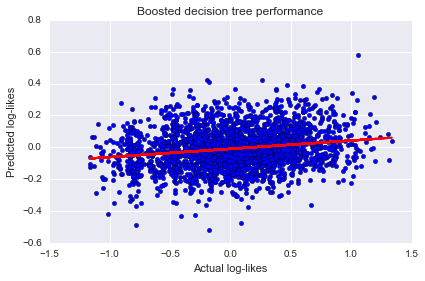

In [51]:
pred_likes = trained_2.predict(validation_data)

from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(data["validation"]["y"], pred_likes)

calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, validation_data.get_label())

plt.scatter(data["validation"]["y"], pred_likes)
plt.plot(data["validation"]["y"], data["validation"]["y"]*lin.coef_ + lin.intercept_, color='red', linewidth=2)
plt.xlabel('Actual log-likes')
plt.ylabel('Predicted log-likes')
plt.title('Boosted decision tree performance')
plt.tight_layout()
plt.savefig('boosted_scatter.png', dpi=300)

In [52]:
pickle.dump(trained_2, open('tree-without-users-eta-0.05-max-depth-6-subsample-1.p', 'w'))

In [61]:
eta = 0.05
subsample = 1.0
max_depth = 4
per_round = 10

score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, data["validation"]["y"]*0, data["validation"]["y"])
print("starting score: " + str(score))

user_hot_train = user_hot[data["training"]["observations"], :]
norm_likes = data["training"]["y"].copy()

params = {"nthread": 4, "eta": eta, "max_depth": max_depth, "subsample": subsample, "silent": 1}
print("params: " + str(eta) + "," + str(max_depth) + ", " + str(subsample))

user_factor = np.zeros((len(data["training"]["users"]), 50))

for i in range(100):
    
    if (i != 0):
        trained = xgb.train(params, training_data, num_boost_round=per_round, 
              verbose_eval=True, xgb_model='save.xgb')
    else:
        trained = xgb.train(params, training_data, num_boost_round=per_round,
            verbose_eval=True)

    trained.save_model('save.xgb')
    
    score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, trained.predict(validation_data), data["validation"]["y"])
    print("   " + str((i+1)*per_round) + "-score: " + str(score))
    
    pred_likes = trained.predict(training_data)
#     like_errors = []
    
#     jj = 0
    for j in data["training"]["users"]:
        like_error = np.mean(norm_likes[user_hot_train[:, j] == 1] - pred_likes[user_hot_train[:,j] == 1])
#         like_errors.append(like_error)
#         user_factor[jj, i] = np.sum(user_factor[jj, :]) + like_error*0.2
#         jj += 1
        norm_likes[user_hot_train[:,j] == 1] -= like_error * 0.2

    training_data = xgb.DMatrix(data["training"]["X"], label=norm_likes)

starting score: 0.499556200393
params: 0.05,4, 1.0
   10-score: 0.547879149953
   20-score: 0.554006998378
   30-score: 0.555526158573
   40-score: 0.558444994453
   50-score: 0.557591533669
   60-score: 0.556533242298
   70-score: 0.557557395238
   80-score: 0.558794913374
   90-score: 0.558948536315
   100-score: 0.560126312196
   110-score: 0.56042502347
   120-score: 0.561329691901
   130-score: 0.561636937783
   140-score: 0.560501834941
   150-score: 0.561474780234
   160-score: 0.560894426901
   170-score: 0.560100708372
   180-score: 0.560168985235
   190-score: 0.560331142784
   200-score: 0.560399419647
   210-score: 0.560314073568
   220-score: 0.560407954255
   230-score: 0.560911496117
   240-score: 0.560493300333
   250-score: 0.561816164547
   260-score: 0.56251600239
   270-score: 0.562720832978
   280-score: 0.563164632585
   290-score: 0.563924212682
   300-score: 0.564777673466
   310-score: 0.564777673466
   320-score: 0.564939831015
   330-score: 0.565690876504
   

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


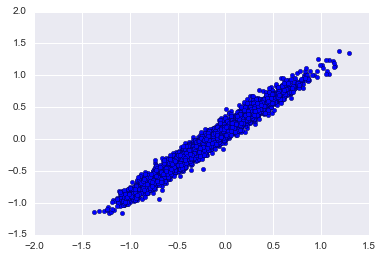

In [74]:
cuv = []
muv = []

for un in range(user_hot_train.shape[1]):
    calc_user_value = (np.mean(data["training"]["y"][user_hot_train[:, un] == 1] - norm_likes[user_hot_train[:, un] == 1]))
    mean_user_value = (np.mean(data["training"]["y"][user_hot_train[:, un] == 1]))
    
    cuv.append(calc_user_value)
    muv.append(mean_user_value)
    
plt.scatter(cuv, muv)

In [81]:
# training_data = xgb.DMatrix(data["training"]["X"], label=data["training"]["y"])
# validation_data = xgb.DMatrix(data["validation"]["X"], label=data["validation"]["y"])

# eta = 0.1
# subsample = 1.0
# max_depth = 2
# num_early_stop = 100

# score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, data["validation"]["y"]*0, data["validation"]["y"])
# print("starting score: " + str(score))
 
# user_hot_train = user_hot[data["training"]["observations"], :]
# norm_likes = data["training"]["y"].copy()

# params = {"nthread": 4, "eta": eta, "max_depth": max_depth, "subsample": subsample, "silent": 1}
# print("params: " + str(eta) + "," + str(max_depth) + ", " + str(subsample))

for i in range(10):
    if i != 0:
        trained = xgb.train(params, training_data, num_boost_round=5000, evals = [[validation_data, "validation"]], 
                      feval = lambda preds, dtrain: 
                                list([["error", (1 - calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, preds, dtrain.get_label()))]]),
                                early_stopping_rounds=num_early_stop, verbose_eval=False)    
    print(str(i) + ": " + str(trained.best_score))
    pickle.dump(trained, open("boosted-type-2-" + str(i) + "-" + str(trained.best_score) + ".p", "w"))
    
    pred_likes = trained.predict(training_data, ntree_limit=trained.best_iteration)

    for j in data["training"]["users"]:
        like_error = np.mean(data["training"]["y"][user_hot_train[:, j] == 1] - pred_likes[user_hot_train[:,j] == 1])
        norm_likes[user_hot_train[:,j] == 1] = data["training"]["y"][user_hot_train[:, j] == 1] - like_error

    training_data = xgb.DMatrix(data["training"]["X"], label=norm_likes)

0: 0.431416
1: 0.434949
2: 0.420312
3: 0.421507
4: 0.432193


KeyboardInterrupt: 

3: 0.420773


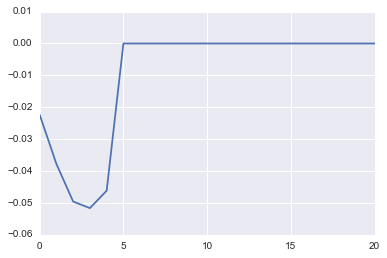

4: 0.423052


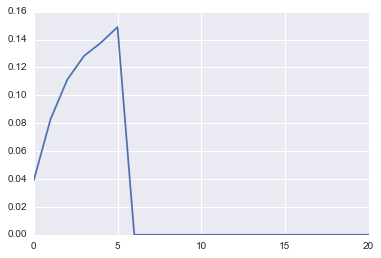

5: 0.423649


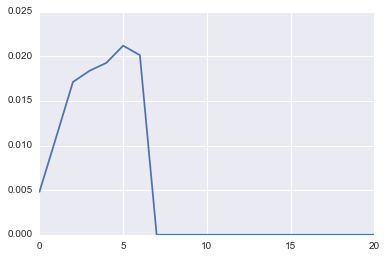

6: 0.430605


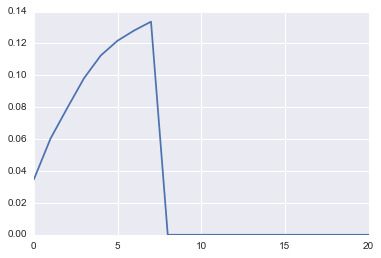

7: 0.426398


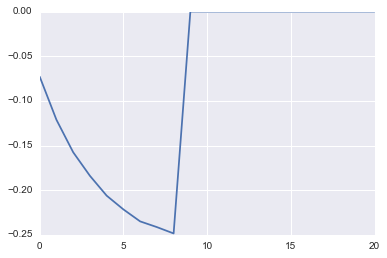

8: 0.434386


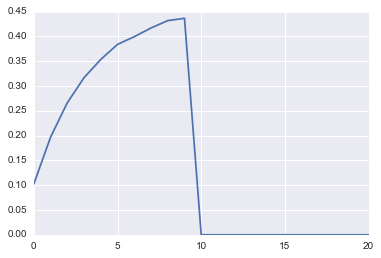

KeyboardInterrupt: 

In [17]:
# training_data = xgb.DMatrix(data["training"]["X"], label=data["training"]["y"])
# validation_data = xgb.DMatrix(data["validation"]["X"], label=data["validation"]["y"])

# eta = 0.1
# subsample = 1.0
# max_depth = 2
# num_early_stop = 100
# alpha = 0.25

# score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, data["validation"]["y"]*0, data["validation"]["y"])
# print("starting score: " + str(score))

# user_hot_train = user_hot[data["training"]["observations"], :]
# norm_likes = data["training"]["y"].copy()

params = {"nthread": 4, "eta": eta, "max_depth": max_depth, "subsample": subsample, "silent": 1}
# print("params: " + str(eta) + "," + str(max_depth) + ", " + str(subsample))

# like_errors = np.zeros((len(data["training"]["users"]), 21))
# pred_likes = data["training"]["y"] * 0
# global_error = np.mean(data["training"]["y"] - pred_likes)

# jj = 0
# i = 0
# for j in data["training"]["users"]:
#     like_error = np.mean(data["training"]["y"][user_hot_train[:, j] == 1] - pred_likes[user_hot_train[:,j] == 1])
#     like_errors[jj, i] = (like_error - global_error) * alpha
#     norm_likes[user_hot_train[:,j] == 1] = data["training"]["y"][user_hot_train[:, j] == 1] - like_errors[jj, i]
#     jj += 1

# training_data = xgb.DMatrix(data["training"]["X"], label=norm_likes)

for i in range(3, 20):
    trained = xgb.train(params, training_data, num_boost_round=5000, evals = [[validation_data, "validation"]], 
          feval = lambda preds, dtrain: 
                    list([["error", (1 - calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, preds, dtrain.get_label()))]]),
                    early_stopping_rounds=num_early_stop, verbose_eval=False)  
        
    print(str(i) + ": " + str(trained.best_score))
    pickle.dump(trained, open("boosted-type-3-alpha-" + str(alpha) + "-" + str(i) + "-" + str(trained.best_score) + ".p", "w"))
    
    pred_likes = trained.predict(training_data, ntree_limit=trained.best_iteration)

    global_error = np.mean(np.ravel(data["training"]["y"]) - np.ravel(pred_likes))
    
    jj = 0
    for j in data["training"]["users"]:
        like_error = np.mean(data["training"]["y"][user_hot_train[:, j] == 1] - pred_likes[user_hot_train[:,j] == 1])
        like_errors[jj, i+1] = like_errors[jj, i] * (1 - alpha) + (like_error - global_error) * alpha
        norm_likes[user_hot_train[:,j] == 1] = data["training"]["y"][user_hot_train[:, j] == 1] - like_errors[jj, i+1]
        jj += 1
    
    plt.plot(like_errors[np.random.randint(0, len(data["training"]["users"])), :])
    plt.show()
        
    training_data = xgb.DMatrix(data["training"]["X"], label=norm_likes)

(array([   31.,   297.,   654.,  1093.,  1323.,  1194.,   651.,   179.,
           35.,    14.]),
 array([-1.22497736, -0.96321785, -0.70145834, -0.43969883, -0.17793932,
         0.08382018,  0.34557969,  0.6073392 ,  0.86909871,  1.13085822,
         1.39261773]),
 <a list of 10 Patch objects>)

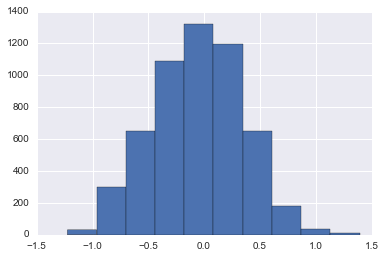

In [11]:
plt.hist(like_errors[:,20])

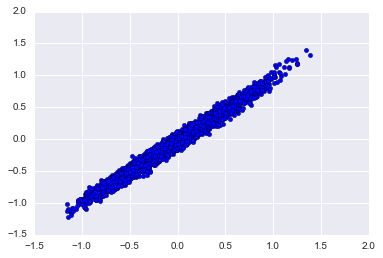

In [13]:
plt.scatter(like_errors[:,0]*2, like_errors[:,20])

In [14]:
model = pickle.load(open("../boosted-trees/models/boosted-type-2-alpha-0.5-eta-0.05-subsample-1-max-depth-6-8-0.41893.p", "r"))

In [35]:
testing_data = xgb.DMatrix(data["test"]["X"], label=data["test"]["y"])

In [15]:
pred_likes = model.predict(validation_data, ntree_limit=model.best_iteration)

0.0390116600966


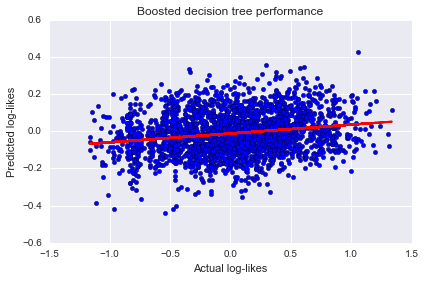

In [16]:
from sklearn import linear_model
plt.scatter(data["validation"]["y"], pred_likes)
lrnr = linear_model.LinearRegression()

lrnr.fit(data["validation"]["y"], pred_likes)
print(lrnr.score(data["validation"]["y"], pred_likes))

plt.plot(data["validation"]["y"], (data["validation"]["y"] * lrnr.coef_ + lrnr.intercept_), color='red', linewidth=2)
plt.xlabel('Actual log-likes')
plt.ylabel('Predicted log-likes')
plt.title('Boosted decision tree performance')
plt.tight_layout()
plt.savefig('boosted_w_user.png', dpi=300)

r^2: 0.0199028868882
r^2: 0.0282640256292
r^2: 0.045312168528
r^2: 0.004095243162
r^2: 0.0941091439331
r^2: 0.00533847868441
r^2: 0.00411168856628
r^2: 0.0611001055489
r^2: 0.0234019753154
r^2: 0.000315457411639
r^2: 0.0114594189945
r^2: 0.00799183666912
r^2: 0.00946364855217
r^2: 0.0149421284838
r^2: 0.00614038860261
r^2: 0.0169170931358
r^2: 0.0141880590715
r^2: 0.0445072145889
r^2: 0.0309532879175
r^2: 0.0438012678414
r^2: 0.088348425289
r^2: 0.00925391704407
r^2: 8.2221833183e-05
r^2: 0.0323294985047
r^2: 0.0043841460157
r^2: 0.3139565942
r^2: 0.00267803846958
r^2: 0.0359543422442
r^2: 0.00332964545454
r^2: 0.0302666097375
r^2: 2.33064455051e-05
r^2: 0.00351832697086
r^2: 0.000233575941012
r^2: 0.000407913693059
r^2: 0.0654620728841


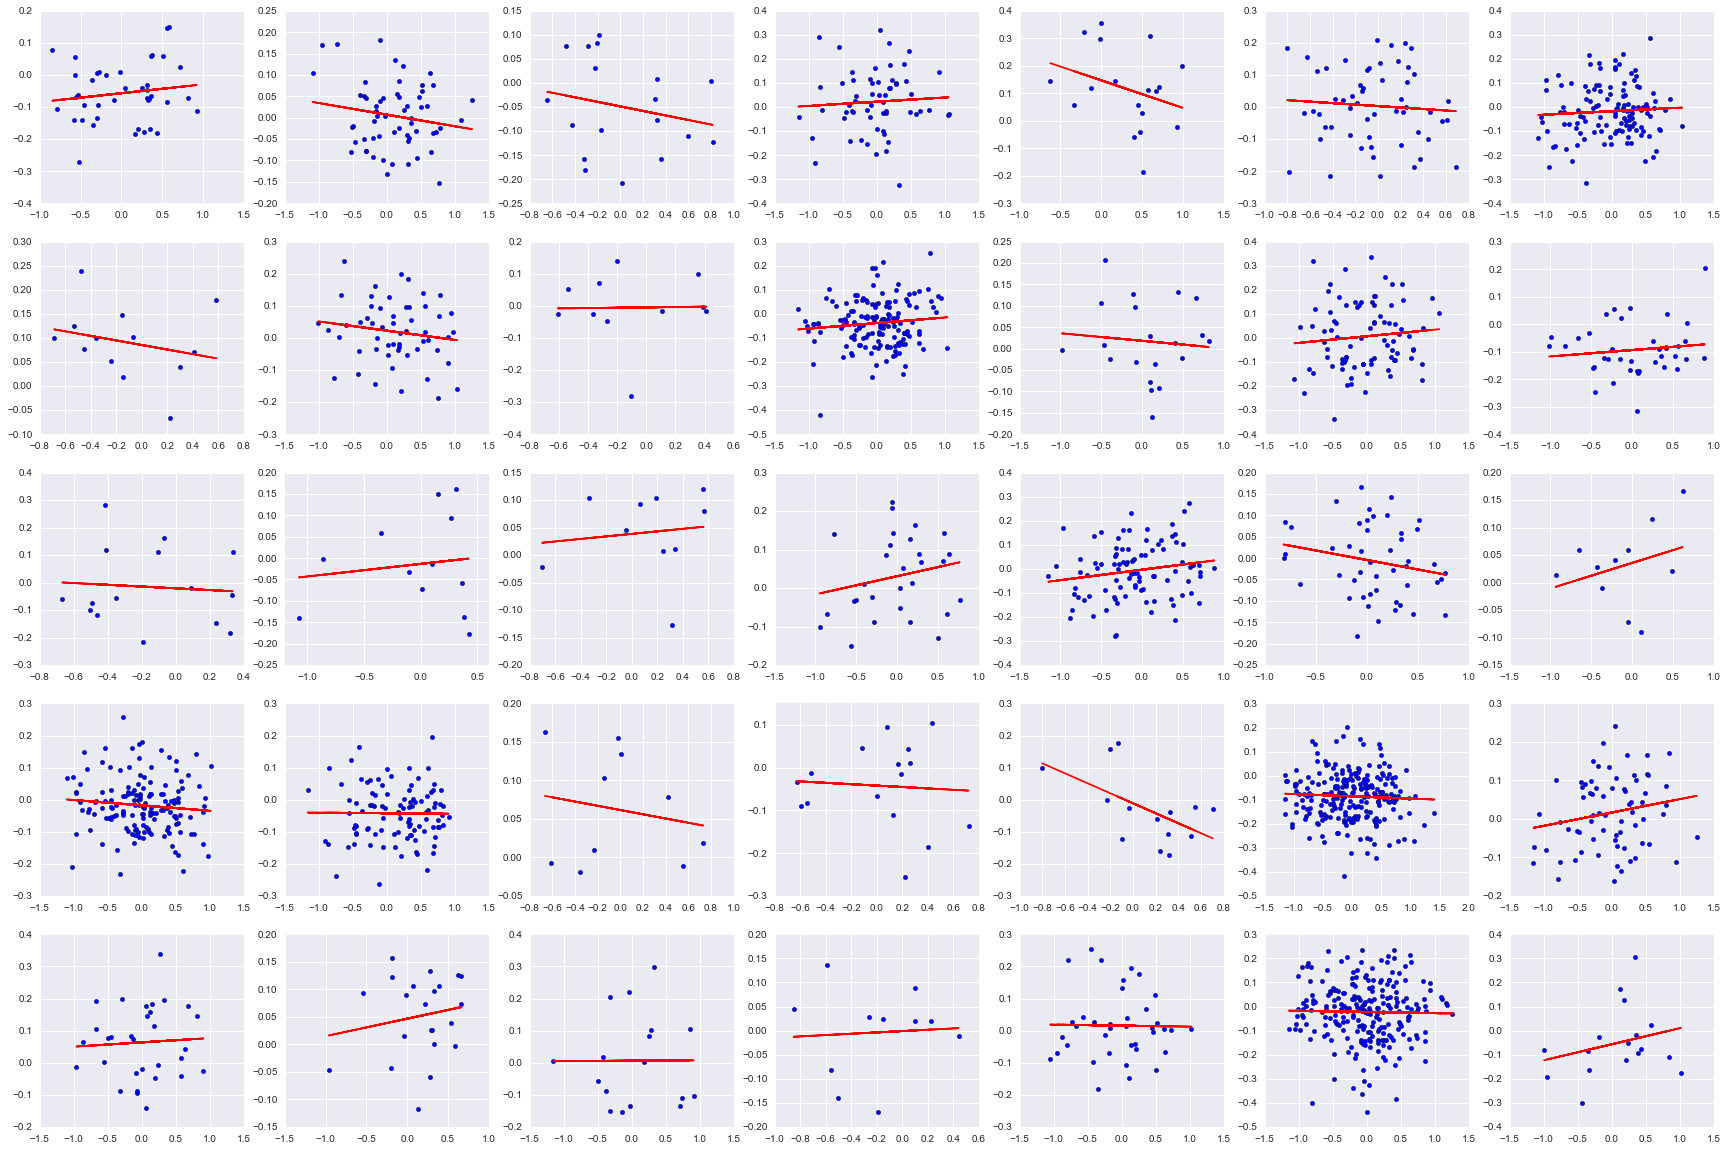

In [17]:
j = 1
plt.figure(figsize=(30, 20))
user_validation = user_hot[data["validation"]["observations"],:]

for i in range(len(data["validation"]["users"])):
    user_test_set = np.any(user_validation[:, [data["validation"]["users"][i]]], axis = 1).nonzero()[0]
    
    if (len(user_test_set)) >= 10:
        plt.subplot(5, 7, j)
        j += 1
        
#         user_dict = {}
#         user_dict[x] = data["validation"]["X"][user_test_set,:]
#         user_dict[y_] = data["validation"]["y"][user_test_set,:] * 0
#         user_dict[keep_prob] = 1.0
        
        ypred = pred_likes[user_test_set]
#         sess.run([y], feed_dict=user_dict)[0]

        y = np.ravel(likes[user_test_set])
        plt.scatter(y, ypred)
#         print('rmse:' + str(calculate_rmse(y, ypred)))

        lin = linear_model.LinearRegression()
        lin.fit(y.reshape((-1, 1)), ypred)
        plt.plot(y.reshape(-1,1), y.reshape(-1,1) * lin.coef_ + lin.intercept_, 'r')
        print("r^2: " + str(lin.score(y.reshape(-1,1), ypred)))

plt.savefig("boost_w_user_user_performance.png", dpi=300)